# Simple RNN

We create a simple RNN here - trying to predict a known sequence. <br>
<i>This is from Udacity's RNN exercise</i>

In [69]:
import torch
from torch import nn

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Show the Sequence

Create and plot the sequence we want to predict using RNN

In [70]:
plt.figure(figsize = (8,5))

seq_length = 20

time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data

array([0.00000000e+00, 1.56434465e-01, 3.09016994e-01, 4.53990500e-01,
       5.87785252e-01, 7.07106781e-01, 8.09016994e-01, 8.91006524e-01,
       9.51056516e-01, 9.87688341e-01, 1.00000000e+00, 9.87688341e-01,
       9.51056516e-01, 8.91006524e-01, 8.09016994e-01, 7.07106781e-01,
       5.87785252e-01, 4.53990500e-01, 3.09016994e-01, 1.56434465e-01,
       1.22464680e-16])

<Figure size 576x360 with 0 Axes>

In [71]:
data.shape

(21,)

In [72]:
data = data.reshape(data.shape[0], 1)
data.shape

(21, 1)

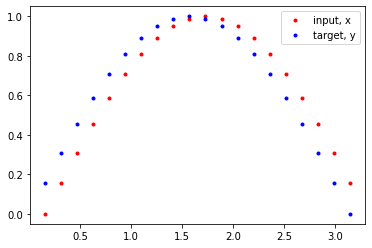

In [73]:
x = data[:-1]
y = data[1:]

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

In [74]:
print(time_steps)

print(time_steps.shape)

[0.         0.15707963 0.31415927 0.4712389  0.62831853 0.78539816
 0.9424778  1.09955743 1.25663706 1.41371669 1.57079633 1.72787596
 1.88495559 2.04203522 2.19911486 2.35619449 2.51327412 2.67035376
 2.82743339 2.98451302 3.14159265]
(21,)


## Define RNN

Architecture: RNN followed by a fully connected neural network

input_size: size of input <br>
output_size: Size of output of the entire model, that is, output from the last fully connected layer <br>
hidden_dim: Size of the output from RNN part of the model <br>
n_layers: Number of layers in RNN part of the model <br>

In [75]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.rnn = nn.RNN(input_size=input_size, hidden_size = hidden_dim, num_layers=n_layers, 
                          batch_first= True)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        """
        x is input of dimension (batch_size, sequence length, feature/input size)
        hidden is initial hidden state
        """
        batch_size = x.size(0)
        r_out, hidden = self.rnn(x, hidden)
        r_out = r_out.view(-1, self.hidden_dim)
        output = self.fc(r_out)
        return output, hidden

### Check / Test the Output and Input Dimension Correctness

In [76]:
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

# generate test data
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data = data.reshape(-1,1)
data.shape

(20, 1)

In [77]:
test_data = torch.Tensor(data).unsqueeze(0)
test_data.shape

torch.Size([1, 20, 1])

### Test Callable Objects in Python

In [78]:
class TestClass:
    def __init__(self, a):
        self.a = a
        
    def doSomething(self, b):
        print("Executing doSomething with parameter: ", b)
        
    def __call__(self, b):
        self.doSomething(b)

t = TestClass(5)

In [79]:
t(6)

Executing doSomething with parameter:  6


## Run the Neural Network

In [80]:
# test the rnn
test_rnn

RNN(
  (rnn): RNN(1, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [81]:
test_out, test_hidden = test_rnn(test_data, None)
print("Model Output size: ", test_out.size())
print("RNN hidden size: ", test_hidden.size())

Model Output size:  torch.Size([20, 1])
RNN hidden size:  torch.Size([2, 1, 10])


## Train the RNN

In [82]:
#Hyper-paramters
input_size = 1
output_size = 1
hidden_dim = 10
n_layers = 2

#instantiate RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


In [83]:
# Loss function
criterion=nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.1)

In [84]:
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
#         loss.backward(retain_graph = True)
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn        
        
        
# def define_training_data(step):
#     time_steps = np.linspace(step*np.pi, (step + 1) *np.pi, seq_length+1)
#     data = np.sin(time_steps)
#     data = data.reshape(-1, 1)
#     x = data[:-1]
#     y = data[1:]
    
#     x_tensor = torch.Tensor(x).unsqueeze(0)
#     y_tensor = torch.Tensor(y)
    
#     return x,y,x_tensor, y_tensor, time_steps

Loss:  1.0740162134170532


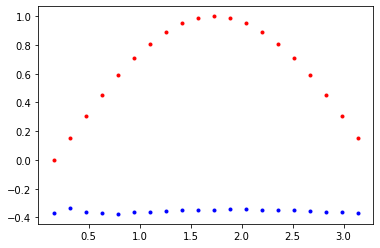

Loss:  0.13548845052719116


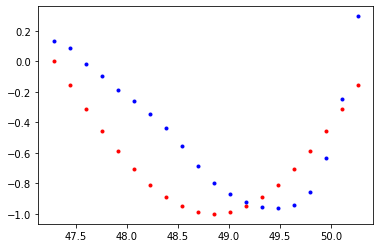

Loss:  0.04030529409646988


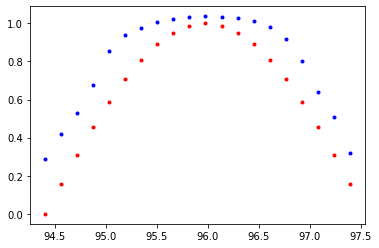

Loss:  0.008973175659775734


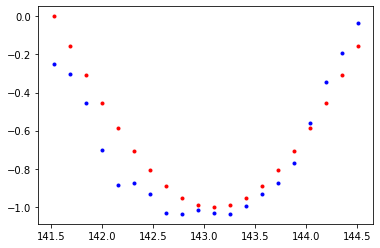

Loss:  0.0035581530537456274


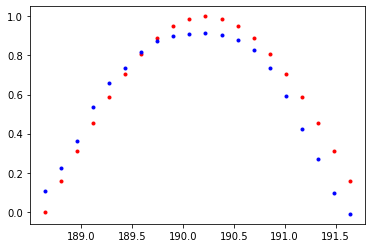

Loss:  0.0005270467954687774


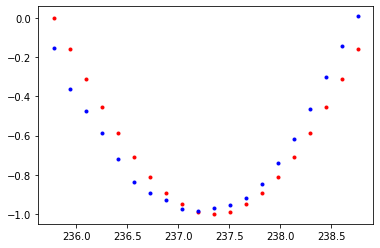

Loss:  0.0003062886244151741


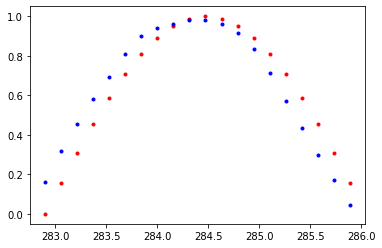

Loss:  0.00021213555010035634


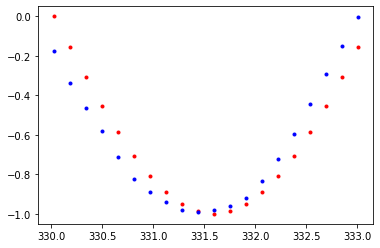

Loss:  0.0001600034156581387


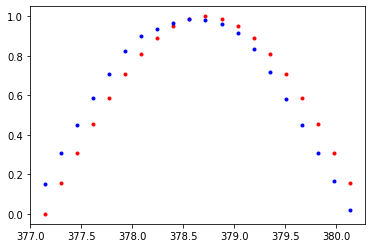

Loss:  0.00010509681305848062


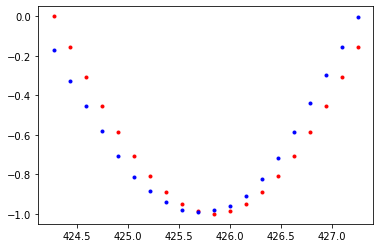

Loss:  0.00010392173862783238


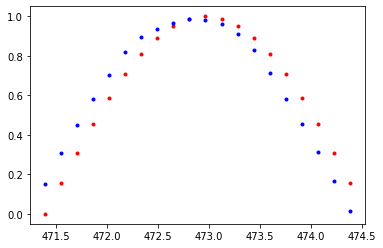

Loss:  7.089151768013835e-05


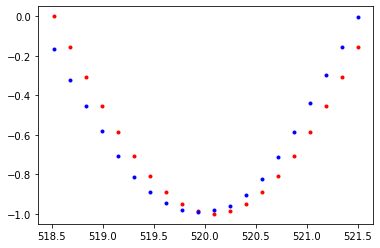

Loss:  7.190628093667328e-05


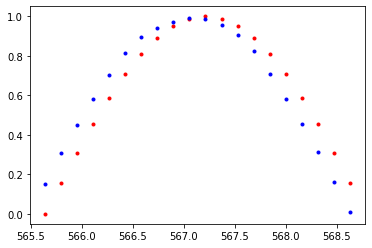

Loss:  5.157625491847284e-05


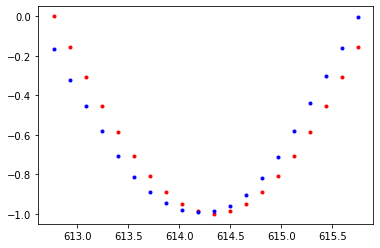

Loss:  5.2619801863329485e-05


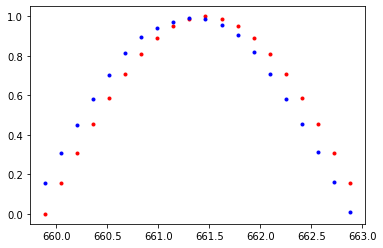

Loss:  3.942411785828881e-05


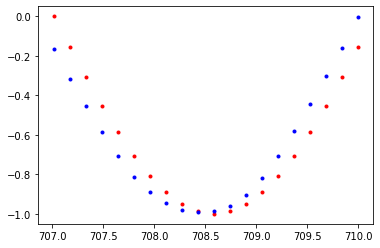

Loss:  4.0311264456249774e-05


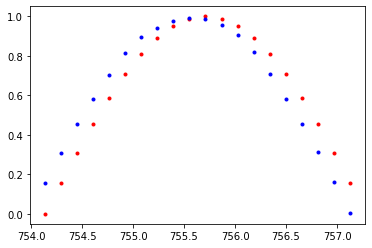

Loss:  3.4780918213073164e-05


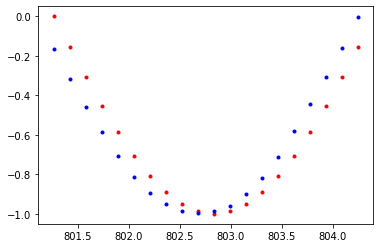

Loss:  0.001028631697408855


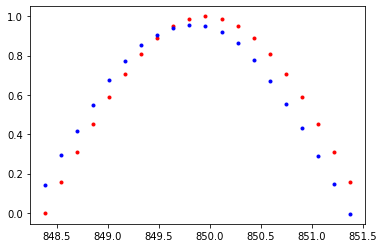

Loss:  0.02062503807246685


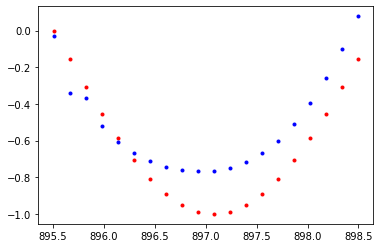

Loss:  0.0014677908038720489


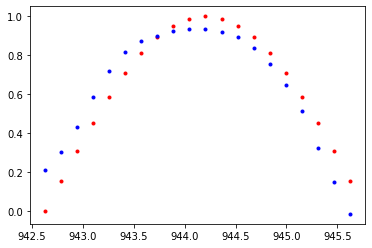

Loss:  0.0007918945630080998


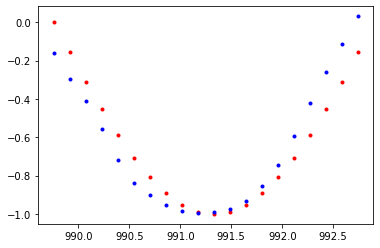

Loss:  0.0004744664765894413


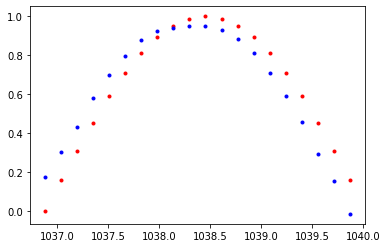

Loss:  0.00016318081179633737


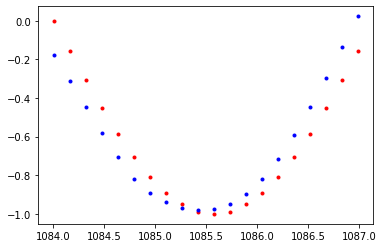

Loss:  0.00010784543701447546


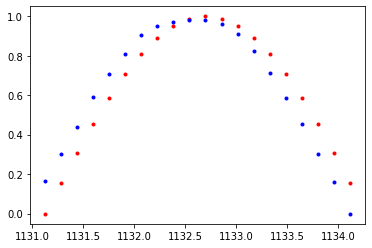

Loss:  8.483440615236759e-05


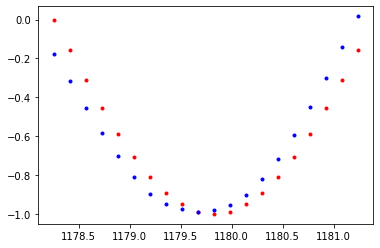

Loss:  8.951261406764388e-05


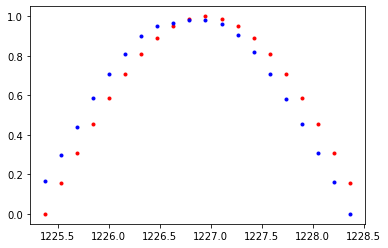

Loss:  6.87415013089776e-05


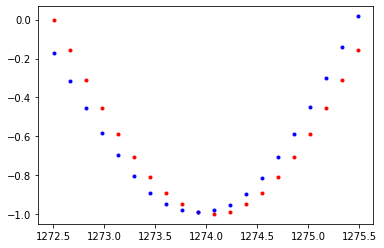

Loss:  8.015620551304892e-05


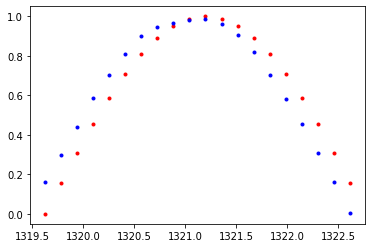

Loss:  9.120771574089304e-05


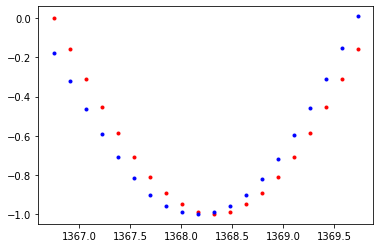

Loss:  0.062117546796798706


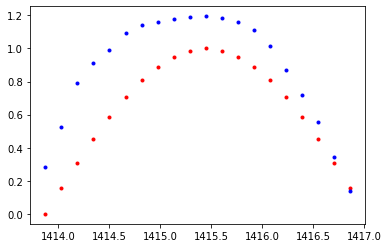

Loss:  0.004268919583410025


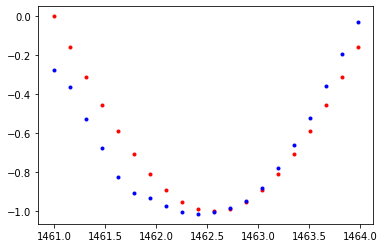

Loss:  0.0027843236457556486


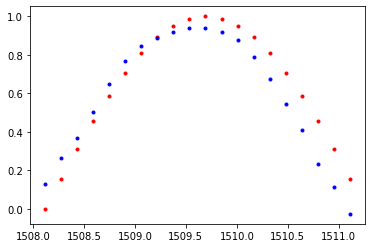

Loss:  0.0003995074948761612


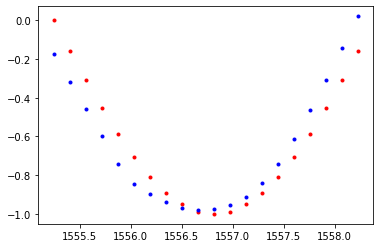

Loss:  0.00031221413519233465


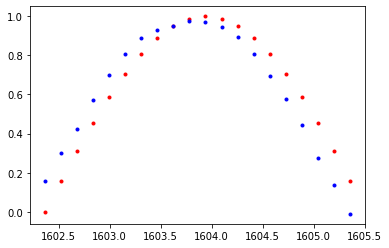

Loss:  0.00015553821867797524


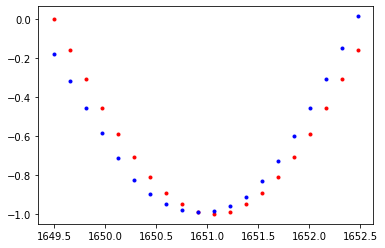

Loss:  0.000166761499713175


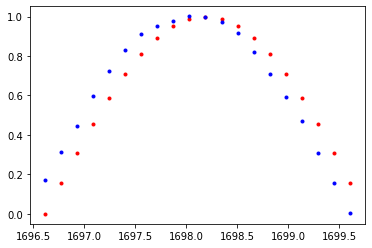

Loss:  0.00031407905044034123


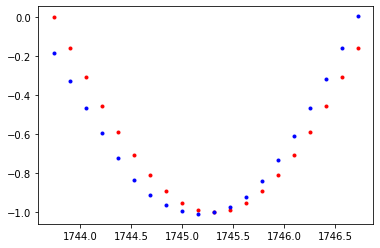

Loss:  0.006649781949818134


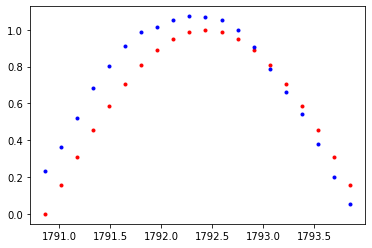

Loss:  0.008418140932917595


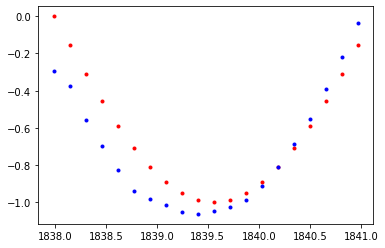

Loss:  0.001646067132242024


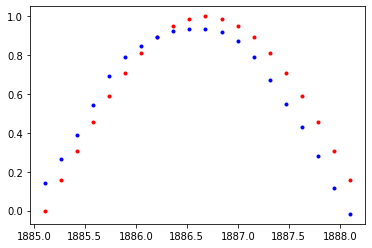

Loss:  0.000276606238912791


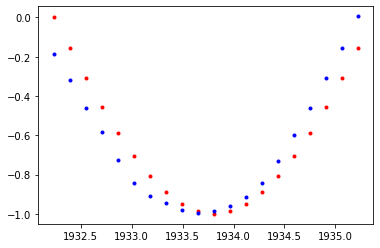

Loss:  0.0004258877015672624


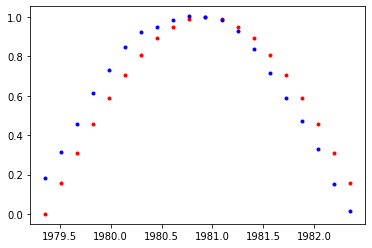

Loss:  0.0014170798240229487


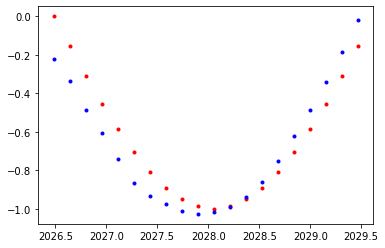

Loss:  0.0017191738588735461


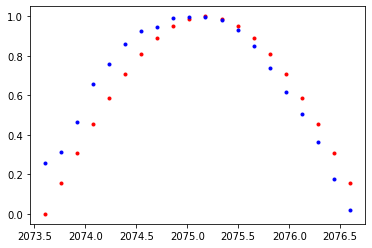

Loss:  0.002563420683145523


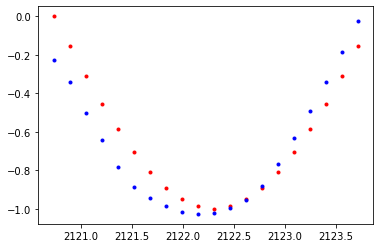

Loss:  0.00043081658077426255


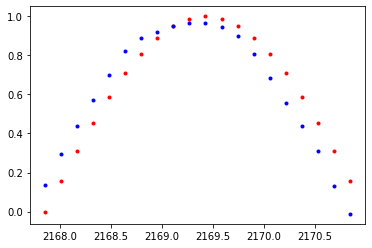

Loss:  0.0002114790549967438


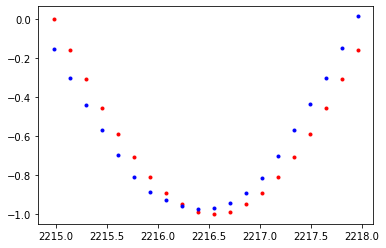

Loss:  0.0001718270214041695


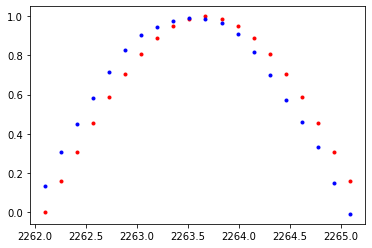

Loss:  0.01669049635529518


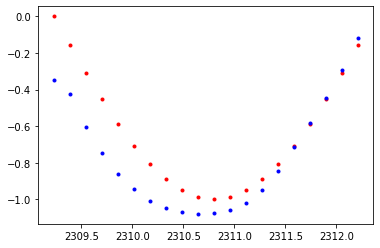

Loss:  0.0011565139284357429


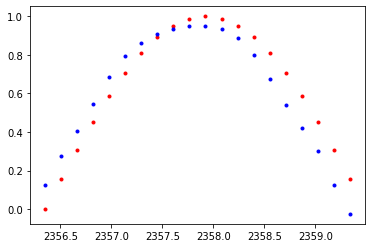

Loss:  0.0018276002956554294


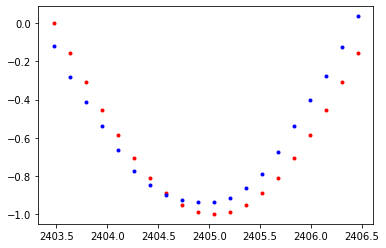

Loss:  0.0005599475116468966


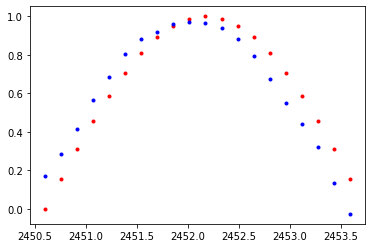

Loss:  0.002538076601922512


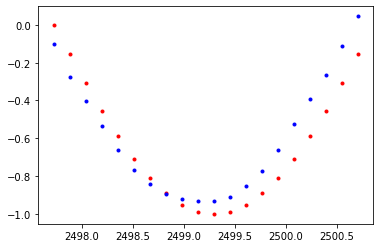

Loss:  0.0005107192555442452


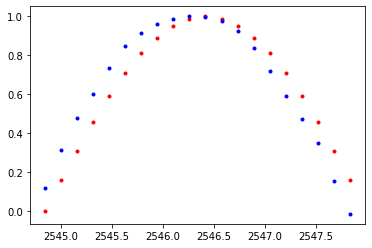

Loss:  0.0030386445578187704


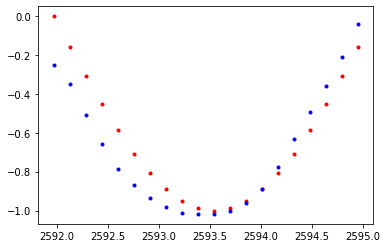

Loss:  0.010832225903868675


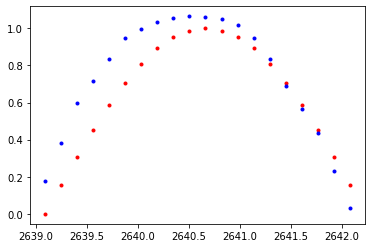

Loss:  0.008716486394405365


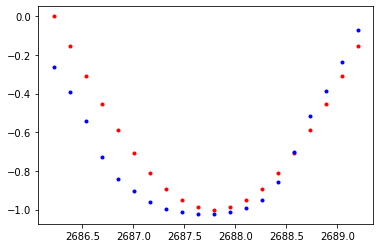

Loss:  0.00028740649577230215


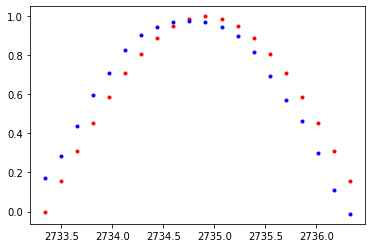

Loss:  0.00044946055277250707


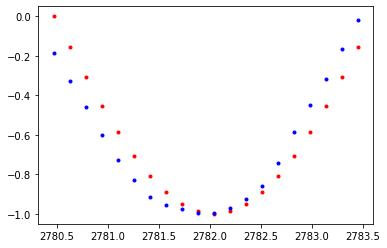

Loss:  0.00010919120541075245


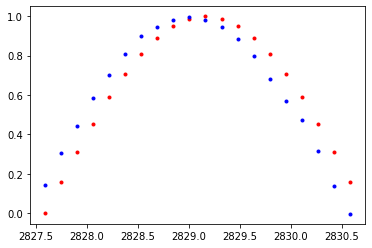

Loss:  0.0007597243529744446


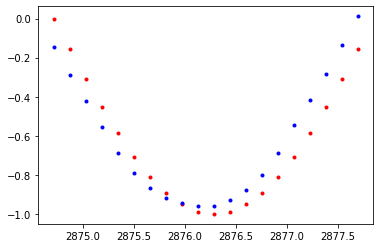

Loss:  0.00668270094320178


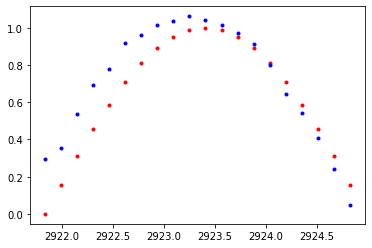

Loss:  0.0013355849077925086


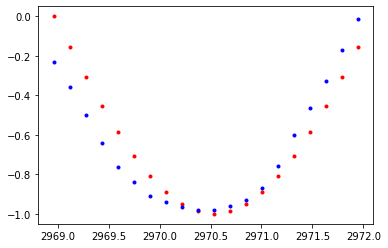

Loss:  0.0004881736822426319


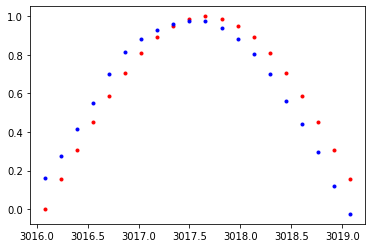

Loss:  0.00031414450495503843


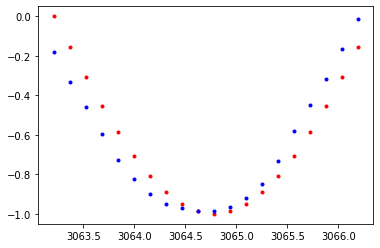

Loss:  0.0002897457161452621


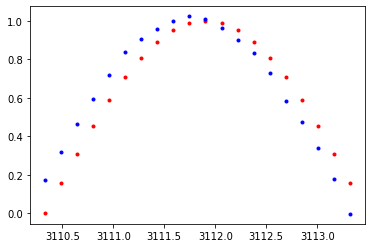

In [85]:
# train the rnn and monitor results
n_steps = 1000
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)

# Observations

Less number of hidden states (10) gives better results than higher number (32) !!!
Why